In [1]:
# comm = MPI.COMM_WORLD
rank = 0 # MPI.Comm_rank(comm)
root = 0
commsize = 4 # MPI.Comm_size(comm)

4

In [39]:
include("mode_init/MPAS_OceanHalos.jl")

moveArrays! (generic function with 2 methods)

In [26]:
println("loading ocean from file")

fullOcean = MPAS_Ocean("MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic", "base_mesh.nc", "mesh.nc", periodicity="Periodic")
"ocean loaded"

loading ocean from file


"ocean loaded"

In [29]:
cells = myCells
outerCells = [myCells...]
newCells = []
haloCells = []

Any[]

In [41]:
for iCell in outerCells
    for jCell in fullOcean.cellsOnCell[:,iCell]
        if ! (jCell in outerCells) && !(jCell in cells) && !(jCell in haloCells)
            append!(newCells, jCell)
        end
    end
end

In [42]:
newCells

1232-element Vector{Any}:
  276
  326
  400
  350
  326
  400
  326
  376
  426
  500
  450
  400
  426
    ⋮
 2432
 2439
 2440
 2440
 2441
  141
  140
  141
 2450
   49
 2498
 2449

In [43]:
println("dividing ocean")

halowidth = 4

cellsInChunk, edgesInChunk, verticesInChunk, cellsFromChunk, cellsToChunk = divide_ocean(fullOcean, halowidth, 2, 2)#; iChunk = rank+1)

myCells = cellsInChunk[rank+1] # cellsedgesvertices[1]
myEdges = edgesInChunk[rank+1] # cellsedgesvertices[2]
myVertices = verticesInChunk[rank+1] # cellsedgesvertices[3]

myOcean = mpas_subset(fullOcean, myCells, myEdges, myVertices)
"subset made"

dividing ocean


"subset made"

In [ ]:
# MPI.Barrier(comm)

# println("ocean distributed between ranks.")

############### Ocean is now distributed between nodes. Let's do some simulation ####################

In [44]:
# set up initial condition

include("mode_init/initial_conditions.jl")

gaussianInit!(myOcean)

# MPI.Barrier(comm)

println("initial condition set.")

initial condition set.


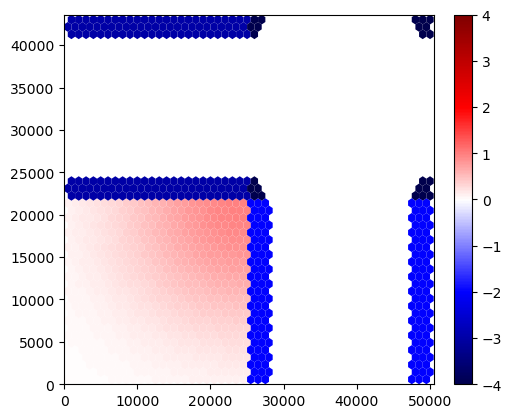

In [47]:
include("visualization.jl")

fig, ax, _ = heatMapMesh(myOcean, myOcean.sshCurrent)
display(fig)

In [46]:
for (srcchunk, localcells) in cellsFromChunk[1]
    if srcchunk != 1
        myOcean.sshCurrent[localcells] .= -srcchunk
    end
end

In [ ]:
# simulate for a while

include("mode_forward/time_steppers.jl")

nFrames = 10

mpasOcean = myOcean

sshOverTime = zeros(nFrames, mpasOcean.nCells)

for f in 1:nFrames
	# simulate until the halo areas are all invalid and need to be updated
	for h in 1:halowidth
		forward_backward_step!(mpasOcean)
	end

	### request cells in my halo from chunks with those cells
	halobufferssh = [] # temporarily stores new halo ssh
	halobuffernv = [] # temporarily stores new halo normal velocity
	recreqs = []
	for (srcchunk, localcells) in cellsFromChunk[rank+1]	
		newhalossh = Array{eltype(mpasOcean.sshCurrent)}(undef, length(localcells))
		append!(halobufferssh, [newhalossh])
		reqssh = MPI.Irecv!(newhalossh, srcchunk-1, 0, comm) # tag 0 for ssh
		append!(recreqs, [reqssh])

		localedges = collect(Set(mpasOcean.edgesOnCell[:,localcells]))
		newhalonv = Array{eltype(mpasOcean.normalVelocityCurrent)}(undef, length(localedges))
		append!(halobuffernv, [newhalonv])
		reqnv = MPI.Irecv!(newhalonv, srcchunk-1, 1, comm) # tag 1 for norm vel
		append!(recreqs, [reqnv])
	end
	
	MPI.Barrier(comm)
	### send cells in main non-halo area to chunks that need them for their halo
	sendreqs = []
	for (dstchunk, localcells) in cellsToChunk[rank+1]
		reqssh = MPI.Isend(mpasOcean.sshCurrent[localcells], dstchunk-1, 0, comm)
		append!(sendreqs, [reqssh])
		
		localedges = collect(Set(mpasOcean.edgesOnCell[:,localcells])) # Set to remove duplicates
		reqnv = MPI.Isend(mpasOcean.normalVelocityCurrent[localedges], dstchunk-1, 1, comm)
		append!(sendreqs, [reqnv])
	end
	
	### copy the recieved data into the ocean's halo
	MPI.Waitall!([recreqs..., sendreqs...])
	for (i, (_, localcells)) in enumerate(cellsFromChunk[rank+1])
		mpasOcean.sshCurrent[localcells] = halobufferssh[i]
		localedges = collect(Set(mpasOcean.edgesOnCell[:,localcells]))
		mpasOcean.normalVelocityCurrent[localedges] = halobuffernv[i]
	end
	
	sshOverTime[f,:] = mpasOcean.sshCurrent

	if rank == root
		println("iteration $f of $nFrames complete")
	end
end

if rank == root
	println("simulation complete, writing output arrays")
end

using DelimitedFiles

open("out/dist_test_1_ssh_rank_$rank.txt", "w") do io
	writedlm(io, sshOverTime)
end

println("$rank: file written")